# Multiclass Image Classification Project
Group 11:
*   Crista Livia Budiman - 2702271133
*   Tio Nicholas Andrew - 2602203812

# Analisis Sederhana  terhadap Data
Link dataset: https://www.kaggle.com/datasets/varpit94/disaster-images-dataset/code

Dataset yang digunakan terdiri atas 6 kategori utama, yaitu:
1. Damaged_Infrastructure (Earthquake, Infrastucture): gambar kerusakan infrastruktur / dampak gempa. 
2. Fire_Disaster (Urban_Fire, Wild_Fire): gambar kebakaran di urban fire dan wild fire.
3. Human_Damage: gambar dampak bencana terhadap manusia
4. Land_Disaster (Drought, Land_Slide): gambar bencana tanah seperti drought dan land slide.
5. Non_Damage (Non_Damage_Buildings_Street, Non_Damage_Wildfire_Forest, human, sea): gambar tanpa kerusakan, seperti bangunan dan hutan utuh, manusia, dan perairan.
6. Water_Disaster: gambar bencana yang disebabkan oleh air.

Untuk project multiclass image classification ini, terdapat 4 class yang akan digunakan, yaitu Earthquake, Urban_Fire, Land_Slide, dan Water_Disaster. Dari analisis pada tahap data preparation, dapat diketahui bahwa terdapat class imbalance pada Earthquake (jumlah gambarnya jauh lebih sedikit dibandingkan class lainnya), sehingga diperlukan beberapa pendekatan agar proses training tetap optiimal.

# Environment Setup

Import modules and libraries

In [1]:
import zipfile
import random
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing import image ,image_dataset_from_directory 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

Set up seed = 42

In [3]:
SEED_VALUE = 42
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# Data Preparation

## Read Dataset

In [4]:
with zipfile.ZipFile('CDD.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

dataset_root = os.path.join('data', 'Comprehensive Disaster Dataset(CDD)')
dataset_path = 'data'
source_map = {
    'Fire_Disaster/Urban_Fire': 'Urban Fire',
    'Water_Disaster': 'Water Disaster',
    'Land_Disaster/Land_Slide': 'Land Slide',
    'Damaged_Infrastructure/Earthquake': 'Earthquake'
}

In [5]:
image_count = defaultdict(int)
for rel_path, class_name in source_map.items():
    full_path = os.path.join(dataset_root, rel_path)
    if os.path.isdir(full_path):
        count = len([
            fname for fname in os.listdir(full_path)
        ])
        image_count[class_name] += count

print("Jumlah gambar / class sebelum splitting:")
for cls, count in image_count.items():
    print(f"{cls}: {count}")

Jumlah gambar / class sebelum splitting:
Urban Fire: 419
Water Disaster: 1035
Land Slide: 456
Earthquake: 36


## Splitting Data

In [6]:
for split in ['train', 'test']:
    split_dir = os.path.join(dataset_path, split)
    if os.path.exists(split_dir):
        shutil.rmtree(split_dir)

In [7]:
split_ratio = 0.8

for rel_path, label in source_map.items():
    src_folder = os.path.join(dataset_root, rel_path)
    all_files = [f for f in os.listdir(src_folder)]
    random.shuffle(all_files)

    split_idx = int(len(all_files) * split_ratio)
    train_files = all_files[:split_idx]
    test_files = all_files[split_idx:]

    for fname in train_files:
        dst = os.path.join(dataset_path, 'train', label)
        os.makedirs(dst, exist_ok=True)
        shutil.copy(os.path.join(src_folder, fname), os.path.join(dst, fname))

    for fname in test_files:
        dst = os.path.join(dataset_path, 'test', label)
        os.makedirs(dst, exist_ok=True)
        shutil.copy(os.path.join(src_folder, fname), os.path.join(dst, fname))

    print(f"{label} - train: {len(train_files)}, test: {len(test_files)}")

Urban Fire - train: 335, test: 84
Water Disaster - train: 828, test: 207
Land Slide - train: 364, test: 92
Earthquake - train: 28, test: 8


In [8]:
def detect_tf_decode_errors(directory):
    problematic_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                file_path = os.path.join(root, file)
                try:
                    image_data = tf.io.read_file(file_path)
                    _ = tf.image.decode_image(image_data, channels=3)
                except tf.errors.InvalidArgumentError:
                    print("TensorFlow decode error:", file_path)
                    problematic_files.append(file_path)
    return problematic_files

train_dir = "data/train"
test_dir = "data/test"

errors_train = detect_tf_decode_errors(train_dir)
errors_test = detect_tf_decode_errors(test_dir)

TensorFlow decode error: data/train\Land Slide\04_01_0007.png
TensorFlow decode error: data/train\Land Slide\04_01_0335.png
TensorFlow decode error: data/train\Urban Fire\01_01_0060.png
TensorFlow decode error: data/test\Land Slide\04_01_0373.png


In [9]:
files_to_remove = [
    "data/train/Land Slide/04_01_0007.png",
    "data/train/Land Slide/04_01_0335.png",
    "data/train/Urban Fire/01_01_0060.png",
    "data/test/Land Slide/04_01_0373.png"
]

for file_path in files_to_remove:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"file removed: {file_path}")
    else:
        print(f"file not found: {file_path}")

file removed: data/train/Land Slide/04_01_0007.png
file removed: data/train/Land Slide/04_01_0335.png
file removed: data/train/Urban Fire/01_01_0060.png
file removed: data/test/Land Slide/04_01_0373.png


In [10]:
image_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    validation_split=0.2,
    subset="training",
    seed=SEED_VALUE,
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    validation_split=0.2,
    subset="validation",
    seed=SEED_VALUE,
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'test'),
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 1552 files belonging to 4 classes.
Using 1242 files for training.
Found 1552 files belonging to 4 classes.
Using 310 files for validation.
Found 390 files belonging to 4 classes.


In [11]:
label_names = train_ds.class_names

## Normalization

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

Data normalization ini berfungsi untuk meningkatkan akurasi dengan mengubah pixel dari 0-255 (RGB) jadi nilai 0-1.

## Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

Data augmentation berfungsi untuk menghindari overfitting dengan menambah variasi data training secara acak.

## Prefetch

In [14]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Prefetch untuk meningkatkan optimasi performance.

# Modelling and Experimentation

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [23]:
all_labels = []
for images, labels in train_ds.unbatch():
    label_val = labels.numpy()
    if label_val.ndim > 0 and label_val.size > 1:
        label_scalar = np.argmax(label_val)  
    else:
        label_scalar = label_val.item()  
    all_labels.append(label_scalar)
    
all_labels = np.array(all_labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weight_dict = dict(enumerate(class_weights))
print("class weights:", class_weight_dict)

class weights: {0: 14.785714285714286, 1: 1.0315614617940199, 2: 1.154275092936803, 3: 0.4769585253456221}


In [24]:
label_names

['Earthquake', 'Land Slide', 'Urban Fire', 'Water Disaster']

LABEL:

0 - Earthquake ; 1 - Land slide ; 2 - Urban Fire ; 3 - Water Disaster

## Model 1 (from scratch)

In [95]:
def design_model1(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


* Terdiri atas 4 hidden layers dengan aktivasi relu.
* Output layer menggunakan fungsi aktivasi softmax karena digunakan untuk klasifikasi multi-class.

In [96]:
model1 = design_model1()
model1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [97]:
model1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [98]:
history_model1 = model1.fit(train_ds,
                            validation_data=val_ds,
                            epochs=50,
                            callbacks=[early_stop],
                            class_weight=class_weight_dict)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4108 - loss: 15.0298 - val_accuracy: 0.2161 - val_loss: 6.6053
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4622 - loss: 19.9953 - val_accuracy: 0.3000 - val_loss: 7.7551
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5226 - loss: 11.5045 - val_accuracy: 0.3129 - val_loss: 6.0667
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5452 - loss: 5.5791 - val_accuracy: 0.5710 - val_loss: 4.8678
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5416 - loss: 5.5734 - val_accuracy: 0.5548 - val_loss: 2.2883
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5388 - loss: 3.6203 - val_accuracy: 0.5645 - val_loss: 4.6285
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4691 - loss: 2.9169 - val_accuracy: 0.5935 - val_loss: 7.9837
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5648 - loss: 3.6190 - val_accuracy: 0.5774 - val_lo

## Model 2 (params < 10M)

In [29]:
def design_model2(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True

    for layer in base_model.layers[:-50]: 
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

* Output layer menggunakan fungsi aktivasi softmax karena digunakan untuk klasifikasi multi-class.

In [30]:
model2 = design_model2()
model2.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [31]:
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 2,019,588 (7.70 MB)

 Non-trainable params: 402,880 (1.54 MB)

Model 2 memiliki parameter kurang dari 10M, yaitu sebanyak 2,422,468 parameters, dengan trainable parameters sebanyak 2,019,588 parameters.

In [32]:
history_model2 = model2.fit(train_ds,
                            validation_data=val_ds,
                            epochs=50,
                            callbacks=[early_stop],
                            class_weight=class_weight_dict)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 62s 986ms/step - accuracy: 0.3879 - loss: 1.4867 - val_accuracy: 0.7161 - val_loss: 0.7689
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 912ms/step - accuracy: 0.6299 - loss: 0.7792 - val_accuracy: 0.7871 - val_loss: 0.5663
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 903ms/step - accuracy: 0.7661 - loss: 0.5593 - val_accuracy: 0.7871 - val_loss: 0.5522
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 904ms/step - accuracy: 0.7899 - loss: 0.4592 - val_accuracy: 0.7903 - val_loss: 0.5676
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 898ms/step - accuracy: 0.8015 - loss: 0.4186 - val_accuracy: 0.8032 - val_loss: 0.5330
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 891ms/step - accuracy: 0.8403 - loss: 0.3908 - val_accuracy: 0.8323 - val_loss: 0.4742
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 902ms/step - accuracy: 0.8545 - loss: 0.3105 - val_accuracy: 0.8290 - val_loss: 0.5030
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 891ms/step - accuracy: 0.8722 - loss: 0.2794 - val_accu



Berdasarkan hasil evaluation, dapat diketahui bahwa model 2 adalah model yang lebih optimal dibandingkan model 1. 

Oleh karena itu, dilakukan hyperparameter tuning untuk mengetahui best learning rate pada model ini.

In [41]:
def design_tuning_model2(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True

    for layer in base_model.layers[:-50]: 
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [42]:
highest_accuracy= 0
best_learningrate = None
for lr in [0.001, 0.0001, 0.00001]:
    print(f"Learning rate = {lr}")

    tuning_model2 = design_tuning_model2()
    tuning_model2.compile(
        optimizer=keras.optimizers.Adam(learning_rate = lr),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    history_tuning_model2 = tuning_model2.fit(train_ds, 
                                              validation_data = val_ds, 
                                              epochs = 50,
                                              callbacks=[early_stop],
                                              class_weight=class_weight_dict)
    
    val_accuracy = max(history_tuning_model2.history['val_accuracy'])
    if val_accuracy > highest_accuracy:
        highest_accuracy = val_accuracy
        best_learningrate = lr
        best_model = tuning_model2

print(f"Learning rate with the highest accuracy is: {best_learningrate}")

Learning rate = 0.001
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 68s 999ms/step - accuracy: 0.6109 - loss: 1.0254 - val_accuracy: 0.6645 - val_loss: 4.2296
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 910ms/step - accuracy: 0.8141 - loss: 0.5147 - val_accuracy: 0.7935 - val_loss: 0.9461
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 914ms/step - accuracy: 0.7994 - loss: 0.5656 - val_accuracy: 0.6419 - val_loss: 2.0083
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 880ms/step - accuracy: 0.8487 - loss: 0.3830 - val_accuracy: 0.7129 - val_loss: 2.9144
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 891ms/step - accuracy: 0.8579 - loss: 0.4156 - val_accuracy: 0.5548 - val_loss: 2.1558
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 901ms/step - accuracy: 0.8038 - loss: 0.5068 - val_accuracy: 0.4710 - val_loss: 4.0527
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 878ms/step - accuracy: 0.8401 - loss: 0.4438 - val_accuracy: 0.7742 - val_loss: 1.3683
Learning rate = 0.0001
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - 

In [43]:
best_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 6,461,646 (24.65 MB)

 Trainable params: 2,019,588 (7.70 MB)

 Non-trainable params: 402,880 (1.54 MB)

 Optimizer params: 4,039,178 (15.41 MB)

# Evaluation

## Berdasarkan hasil plot accuracy dan loss

In [44]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

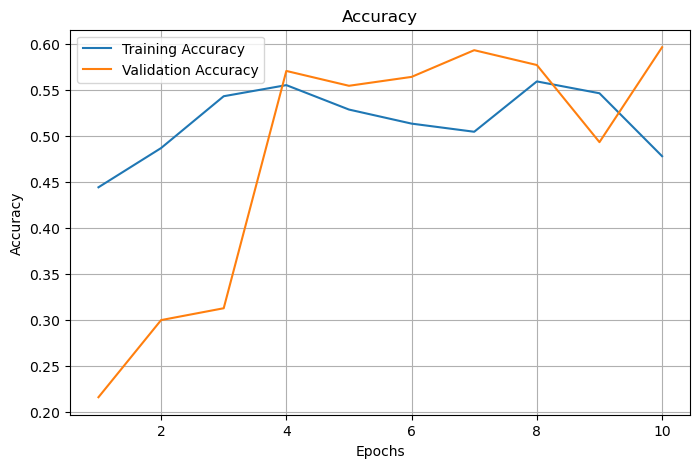

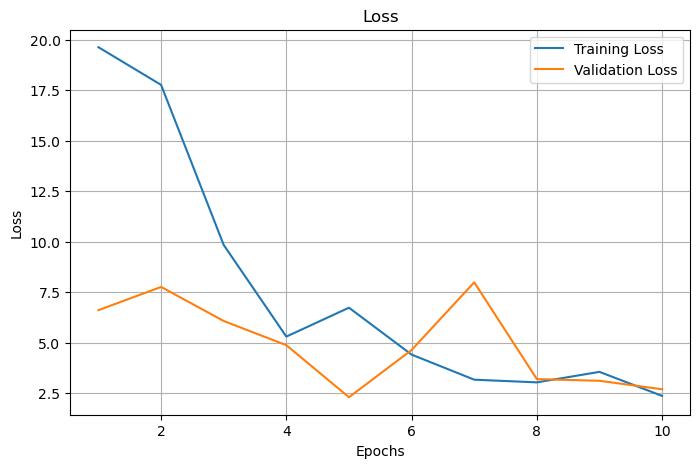

In [99]:
plot_history(history_model1, model1)

Berdasarkan grafik hasil training model 1, dapat dilihat bahwa:
* Training accuracy meningkat secara bertahap dari awal hingga mencapai sekitar 55%–60%, meskipun sempat mengalami penurunan di beberapa epoch terakhir.
* Validation accuracy  mengalami peningkatan signifikan, terutama pada epoch ke-4 hingga ke-8 (lebih tinggi dibandingkan training accuracy).
* Training loss menunjukkan penurunan yang cukup konsisten dari awal (sekitar 20) menjadi sekitar 2.5 di akhir epoch.
* Validation loss sempat naik-turun tapi tetap berada dalam range yang mirip di akhir epoch dengan garis training loss.
  
Secara keseluruhan, grafik ini menunjukkan bahwa model masih dalam proses belajar yang cukup baik, namun performanya masih tergolong moderate karena belum menunjukkan generalisasi yang sangat kuat.

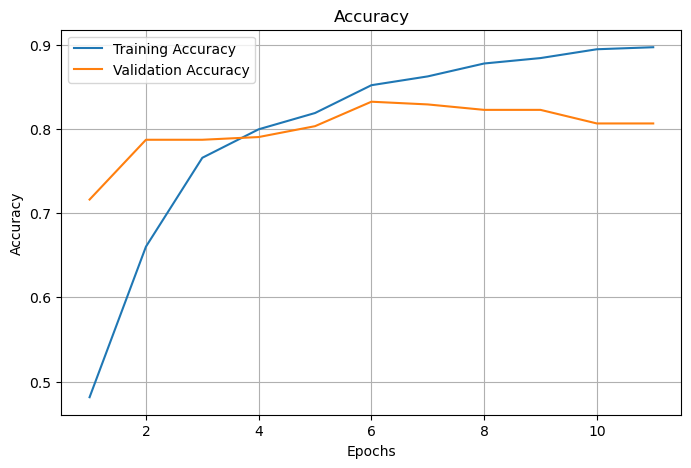

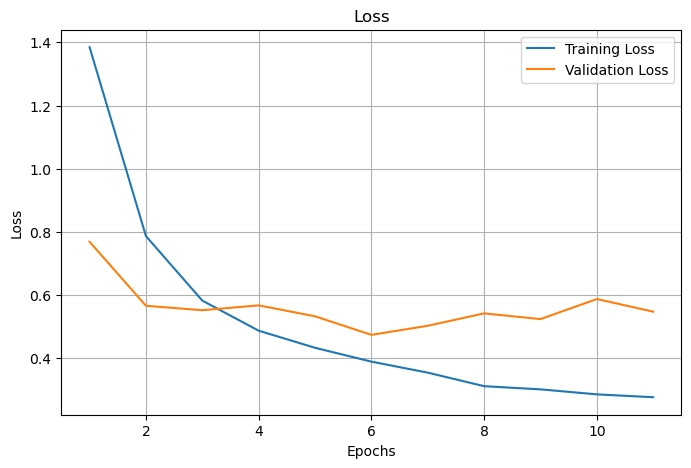

In [46]:
plot_history(history_model2, model2)

Berdasarkan grafik hasil training model 2 (parameter < 10M), dapat dilihat bahwa:
* Training accuracy mempunyai grafik yang meningkat secara stabil dan konsisten, mengalami peningkatan yang signifikan dari 50% hingga 90%.
* Validation accuracy mengalami peningkatan dari 70% ke 80%, kemudia cukup stagnan dari epoch ke-6
Hal tersebut menunjukkan bahwa meskipun model semakin baik dalam mengenali pola pada data training, kemampuannya untuk mengeneralisasi ke data validasi mulai menurun.
* Training loss mengalami penurunan yang signifikan dan stabil, yang menandakan bahwa model terus memperbaiki prediksinya terhadap data yang sudah dikenal.
* Validation loss mengalami penurunan yang cenderung stagnan, bahkan sedikit meningkat setelah epoch ke-6, kemungkinan besar overfitting.

Melalui kedua grafik tersebut, dapat diketahui bahwa model ke-2 yang memanfaatkan arsitektur MobileNetV2 ini menunjukkan hasil yang lebih efisien dibandingkan model 1 yang dibuat from scratch. Hal tesebut dikarenakan hasil accuracy training dan validation yang lebih tinggi dan stabil serta grafik loss terus menurun secara konsisten.

## Berdasarkan hasil classification report dan correlation matrix

In [47]:
def evaluate(model, test_ds, label_names):
    y_true = []
    y_pred = []
    for x, y in test_ds:
        pred = model.predict(x)
        y_pred.extend(np.argmax(pred, axis=1))
        y_true.extend(np.argmax(y.numpy(), axis=1))
    
    print(classification_report(y_true, y_pred, target_names=label_names))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=label_names).plot()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
                precision    recall  f1-score   support

    Earthquake       0.00      0.00      0.00         8
    Land Slide       0.34      0.11      0.17        91
    Urban Fire       0.41      0.14      0.21        84
Water Disaster       0.56      0.90      0.70       207

      accuracy                           0.54       390
     macro avg       0.33      0.29      0.27       390
  weighted avg       0.47      0.54      0.45       390



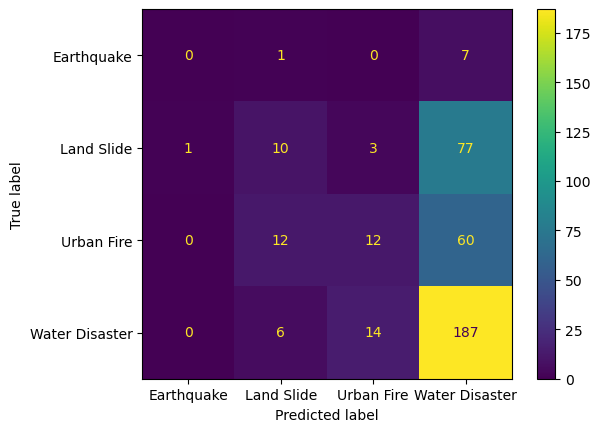

In [100]:
evaluate(model1, test_ds, label_names)

correlation matrix pada model 1 biased terhadap Water Disaster.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
                precision    recall  f1-score   support

    Earthquake       0.32      0.75      0.44         8
    Land Slide       0.81      0.62      0.70        91
    Urban Fire       0.91      0.83      0.87        84
Water Disaster       0.85      0.92      0.88       207

      accuracy                           0.83       390
     macro avg       0.72      0.78      0.72       390
  weighted avg       0.84      0.83      0.83       390



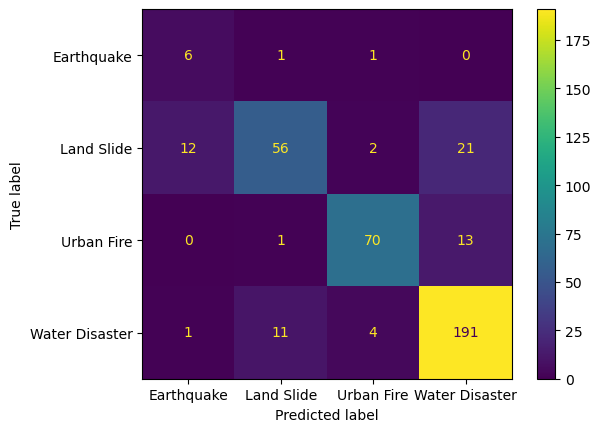

In [49]:
evaluate(model2, test_ds, label_names)

Jika dilihat berdasarkan classification report dan correlation matrix kedua model tersebut, dapat disimpulkan bahwa secara keseluruhan, model ke-2 adalah model yang lebih optimal dibandingkan model ke-1 untuk dataset ini. Model 2 lebih unggul dalam semua metric dan kemampuannya dalam mengklasifikasikan class minoritas seperti Earthquake dengan f1-score yang meningkat signifikan dibanding model pertama. 

## Best Model

BEST MODEL = MODEL 2

Evaluasi untuk best model yang telah di hyperparameter tuning

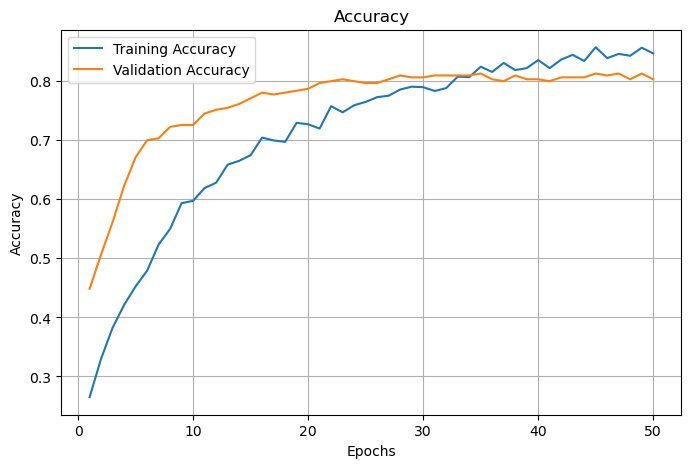

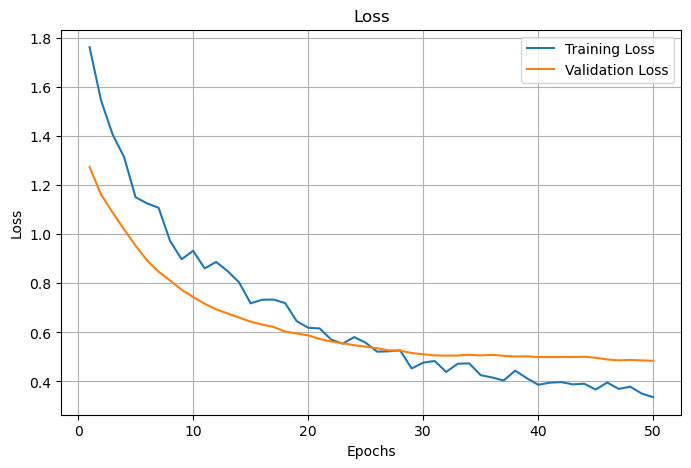

In [50]:
plot_history(history_tuning_model2, best_model)

Berdasarkan grafik hasil training dari best model (model 2 dengan learning rate 0.00001), dapat dilihat bahwa:
* Training accuracy meningkat secara konsisten dari 30% hingga mencapai angka yang cukup tinggi sekitar (hampir 90%) di akhir epoch
* Validation accuracy mengalami peningkatan yang stabil, kemudian cenderung stabil di kisaran 80%–82%
* Training loss menurun signifikan dari awal dan terus berkurang hingga berada di bawah 0.5, menunjukkan bahwa model terus memperbaiki prediksinya terhadap data latih.
* Validation loss juga menunjukkan pola penurunan yang konsisten dan stabil hingga akhir epoch.

Secara keseluruhan, grafik tersebut memperlihatkan bahwa model ini berhasil belajar secara efektif dan mampu melakukan generalisasi dengan baik terhadap data baru. Hasil ini membuktikan bahwa model ini merupakan model yang lebih efisien dibandingkan model 1 karena performanya yang stabil dan tidak menunjukkan gejala overfitting yang serius.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
                precision    recall  f1-score   support

    Earthquake       0.26      0.62      0.37         8
    Land Slide       0.70      0.71      0.71        91
    Urban Fire       0.91      0.94      0.92        84
Water Disaster       0.93      0.86      0.89       207

      accuracy                           0.84       390
     macro avg       0.70      0.78      0.72       390
  weighted avg       0.86      0.84      0.85       390



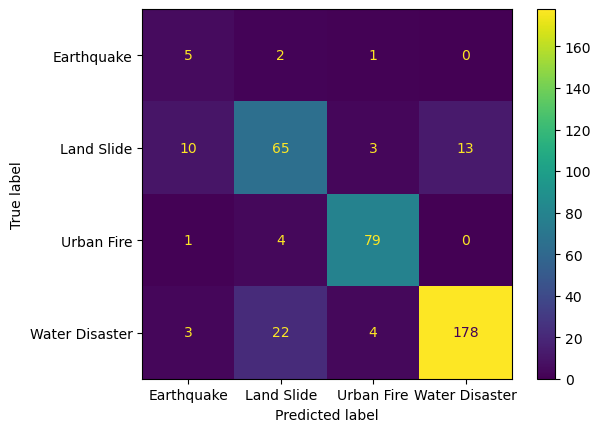

In [102]:
evaluate(best_model, test_ds, label_names)

Hasil accuracy, macro avg, dan weighted model 2 dengan learning rate 0.00001 secara keseluruhan lebih tinggi dibandingkan model 2 dengan learning rate 0.0001.

# Documentation

In [53]:
def predictions_of_the_best_model(model, dataset, num_images, label_names):
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        pred_labels = tf.argmax(preds, axis=1).numpy()
        true_labels = tf.argmax(labels, axis=1).numpy()

        num_to_show = min(num_images, images.shape[0])

        plt.figure(figsize=(18, num_to_show // 5 * 3))
        for i in range(num_to_show):
            ax = plt.subplot((num_to_show + 4) // 5, 5, i + 1)  
            img = (images[i].numpy() * 255).astype("uint8")
            plt.imshow(img)
            plt.title("Hasil prediksi dari best model")
            true_text = label_names[true_labels[i]]
            pred_text = label_names[pred_labels[i]]
            color = "green" if true_text == pred_text else "red"
            plt.title(f"True:\n{true_text}\nPred:\n{pred_text}", fontsize=9, color=color)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


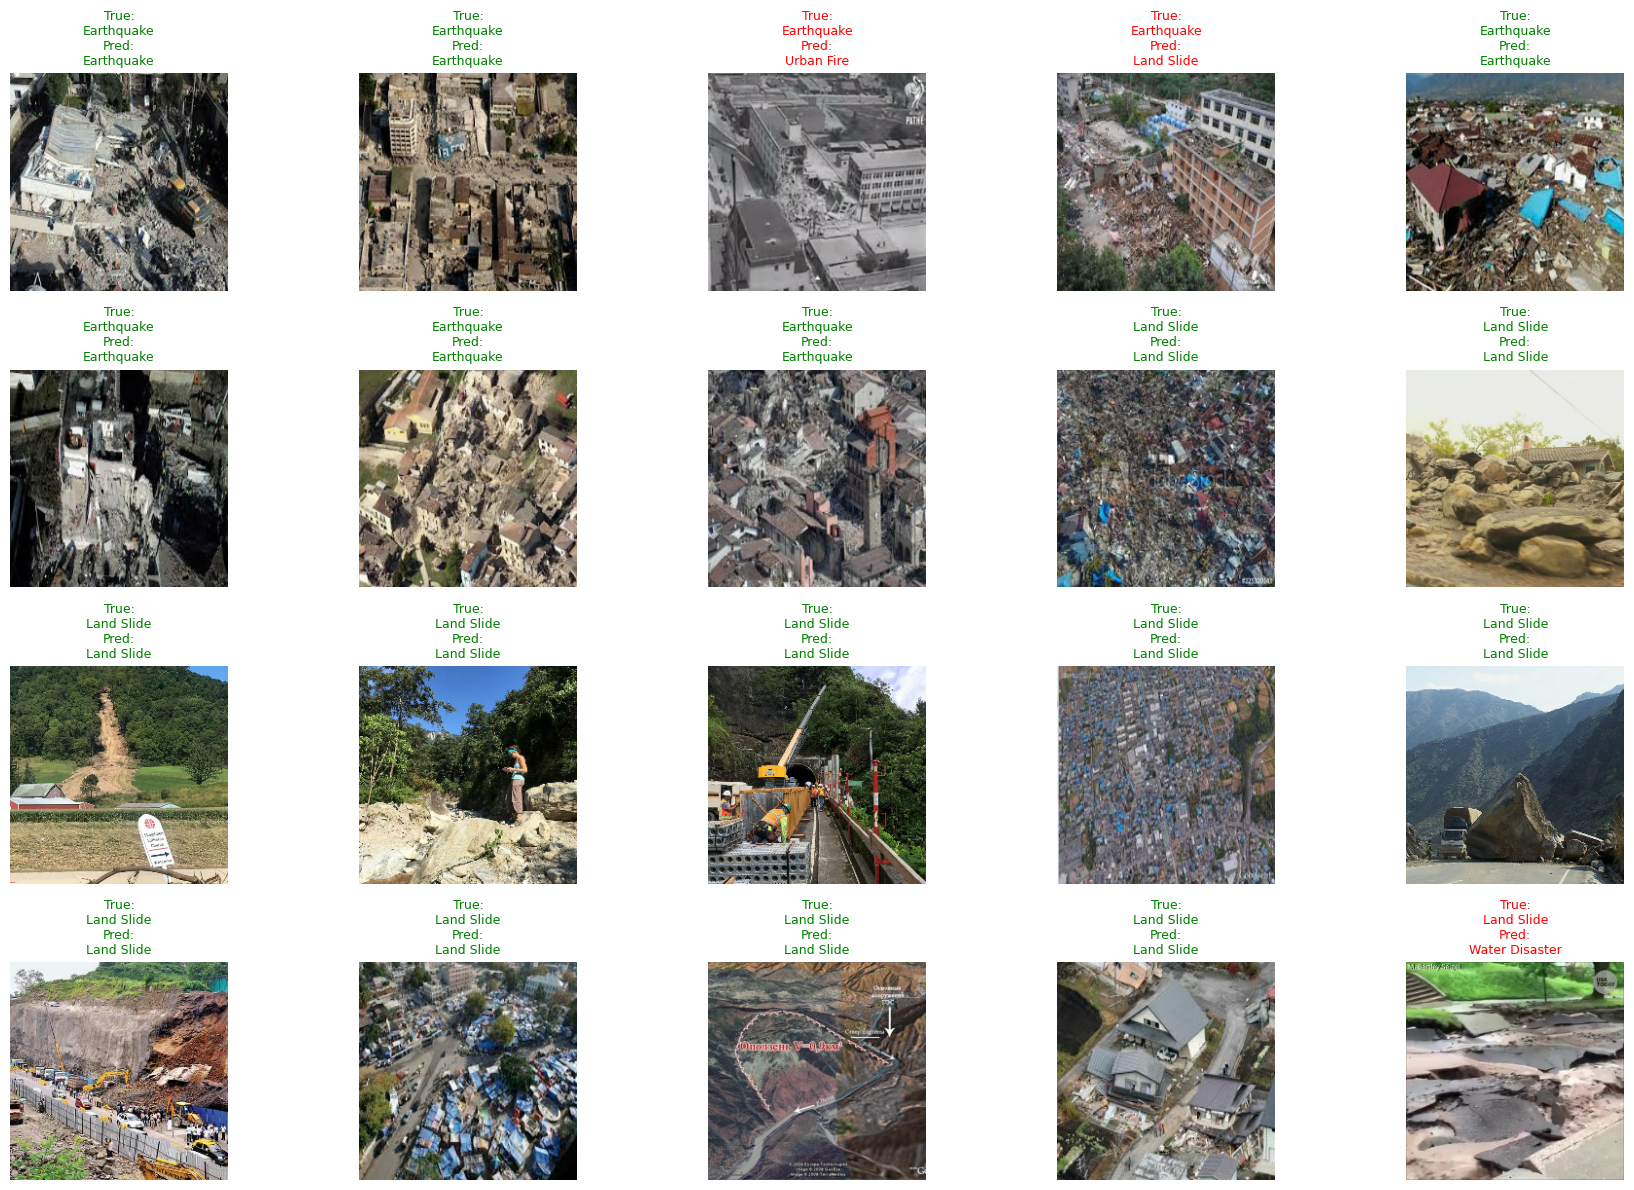

In [54]:
num_images = 20
predictions_of_the_best_model(model2, test_ds, num_images, label_names)

Distribusi data yang digunakan:
* Urban Fire: 419
* Water Disaster: 1035
* Land Slide: 456
* Earthquake: 36 -> unbalanced sehingga menggunakan class_weight dengan perbandingan:
  
Earthquake: 14.785714285714286, Urban Fire: 1.0315614617940199, Land Slide: 1.154275092936803, Water Disaster: 0.4769585253456221


Dimensi setiap gambar di resize menjadi 224 x 224

In [105]:
model1.evaluate(val_ds)
model1.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5557 - loss: 2.3108
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.3081 - loss: 3.9900


[2.5240135192871094, 0.535897433757782]

In [106]:
best_model.evaluate(val_ds)
best_model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.8104 - loss: 0.4712
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step - accuracy: 0.8019 - loss: 0.5480


[0.47193023562431335, 0.8384615182876587]

Model 2 yang menggunakan arsitektur MobileNetV2 (dengan learning rate 0.0001) terbukti lebih unggul dibandingkan model 1. Hal tersebut dikarenakanmodel 2 memanfaatkan arsitektur MobileNetV2 yang memang dirancang untuk efisiensi komputasi, sehingga sangat cocok digunakan dalam proyek klasifikasi gambar seperti ini yang membutuhkan performa tinggi namun tetap ringan dari sisi resource. Dengan memanfaatkan transfer learning dari MobileNetV2, proses training menjadi lebih cepat dan hasilnya juga lebih akurat.

Selain itu, dari hasil training, model 2 menunjukkan akurasi validasi yang lebih tinggi dan lebih stabil dibandingkan model 1, yang menunjukkan bahwa model tidak hanya belajar dengan baik dari data training, tetapi juga mampu melakukan generalisasi dengan lebih baik terhadap data yang belum pernah dilihat sebelumnya. Sedangkan model 1 merupakan arsitektur CNN yang dibangun from scratch, dengan struktur yang relatif sederhana, sehingga model ini kurang mampu menangkap pola fitur yang kompleks dan cenderung menghasilkan model yang bias terhadap data training (contohnya biased pada Water_Disaster).

